In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Custom Dataset Loader

In [5]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}

        folders = sorted(os.listdir(root_dir))
        for idx, folder in enumerate(folders):
            self.label_map[folder] = idx
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.endswith('.png'):
                    self.image_paths.append(os.path.join(folder_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [7]:
import os

# Check directory contents
root = "/kaggle/input/leapgestrecog/leapGestRecog"
print("Top-level folders:", os.listdir(root))

for folder in os.listdir(root):
    folder_path = os.path.join(root, folder)
    print(f"\nChecking folder: {folder}")
    if os.path.isdir(folder_path):
        print("Files inside:", os.listdir(folder_path)[:5])  # show only first 5 files


Top-level folders: ['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

Checking folder: 07
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 05
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 06
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 02
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 04
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 00
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 08
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 09
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 03
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 01
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']


# Transformations & DataLoader

In [8]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        label_idx = 0

        # Traverse subject folders
        for subject in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subject_path):
                continue
            for gesture in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture)
                if not os.path.isdir(gesture_path):
                    continue
                if gesture not in self.label_map:
                    self.label_map[gesture] = label_idx
                    label_idx += 1
                for fname in os.listdir(gesture_path):
                    if fname.endswith(".png"):
                        self.image_paths.append(os.path.join(gesture_path, fname))
                        self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [9]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = LeapGestureDataset("/kaggle/input/leapgestrecog/leapGestRecog", transform=transform)
print("Total samples loaded:", len(dataset))  # Should not be 0

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)


Total samples loaded: 20000


# 🧠 **CNN Model**

In [10]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = CNNModel(num_classes=10).to(device)


# 🔧 **Training Setup**

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_labels


In [13]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [14]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        label_idx = 0

        for subject in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subject_path):
                continue
            for gesture in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture)
                if not os.path.isdir(gesture_path):
                    continue
                if gesture not in self.label_map:
                    self.label_map[gesture] = label_idx
                    label_idx += 1
                for fname in os.listdir(gesture_path):
                    if fname.endswith(".png"):
                        self.image_paths.append(os.path.join(gesture_path, fname))
                        self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [17]:
dataset = LeapGestureDataset('/kaggle/input/leapgestrecog/leapGestRecog', transform=transform)
print("Loaded dataset size:", len(dataset))

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


Loaded dataset size: 20000


# Train the Model

In [18]:
epochs = 15
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc, _, _ = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


Epoch 1/15


100%|██████████| 500/500 [00:03<00:00, 146.08it/s]


Train Loss: 0.3418, Acc: 0.8832
Test Loss: 0.0200, Acc: 0.9960
Epoch 2/15


100%|██████████| 500/500 [00:02<00:00, 194.02it/s]


Train Loss: 0.0159, Acc: 0.9959
Test Loss: 0.0097, Acc: 0.9985
Epoch 3/15


100%|██████████| 500/500 [00:02<00:00, 193.34it/s]


Train Loss: 0.0114, Acc: 0.9967
Test Loss: 0.0078, Acc: 0.9978
Epoch 4/15


100%|██████████| 500/500 [00:02<00:00, 191.66it/s]


Train Loss: 0.0049, Acc: 0.9987
Test Loss: 0.0034, Acc: 0.9992
Epoch 5/15


100%|██████████| 500/500 [00:02<00:00, 192.19it/s]


Train Loss: 0.0051, Acc: 0.9987
Test Loss: 0.0171, Acc: 0.9960
Epoch 6/15


100%|██████████| 500/500 [00:02<00:00, 193.02it/s]


Train Loss: 0.0155, Acc: 0.9957
Test Loss: 0.0025, Acc: 0.9995
Epoch 7/15


100%|██████████| 500/500 [00:02<00:00, 192.83it/s]


Train Loss: 0.0018, Acc: 0.9993
Test Loss: 0.0031, Acc: 0.9995
Epoch 8/15


100%|██████████| 500/500 [00:02<00:00, 189.78it/s]


Train Loss: 0.0002, Acc: 1.0000
Test Loss: 0.0028, Acc: 0.9995
Epoch 9/15


100%|██████████| 500/500 [00:02<00:00, 193.07it/s]


Train Loss: 0.0001, Acc: 1.0000
Test Loss: 0.0033, Acc: 0.9995
Epoch 10/15


100%|██████████| 500/500 [00:02<00:00, 193.85it/s]


Train Loss: 0.0092, Acc: 0.9976
Test Loss: 0.0333, Acc: 0.9915
Epoch 11/15


100%|██████████| 500/500 [00:02<00:00, 193.78it/s]


Train Loss: 0.0180, Acc: 0.9949
Test Loss: 0.0164, Acc: 0.9972
Epoch 12/15


100%|██████████| 500/500 [00:02<00:00, 191.33it/s]


Train Loss: 0.0017, Acc: 0.9994
Test Loss: 0.0069, Acc: 0.9992
Epoch 13/15


100%|██████████| 500/500 [00:02<00:00, 192.91it/s]


Train Loss: 0.0004, Acc: 0.9998
Test Loss: 0.0047, Acc: 0.9995
Epoch 14/15


100%|██████████| 500/500 [00:02<00:00, 193.12it/s]


Train Loss: 0.0046, Acc: 0.9988
Test Loss: 0.0089, Acc: 0.9990
Epoch 15/15


100%|██████████| 500/500 [00:02<00:00, 191.81it/s]


Train Loss: 0.0009, Acc: 0.9998
Test Loss: 0.0044, Acc: 0.9995


In [21]:
# After training
_, _, y_pred, y_true = evaluate(model, test_loader)

from sklearn.metrics import accuracy_score

overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Test Accuracy: {overall_accuracy * 100:.2f}%")



✅ Overall Test Accuracy: 99.95%


In [22]:
from sklearn.metrics import classification_report, accuracy_score

# Get predictions after training
_, _, y_pred, y_true = evaluate(model, test_loader)

# Print Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = accuracy_score(y_true, y_pred)

# Convert report to readable format
import pandas as pd

df_report = pd.DataFrame(report).transpose()
df_report = df_report.rename(index={'accuracy': 'overall_accuracy'})

# Display report
print("📋 Classification Report:")
print(df_report)

# Print only the final overall scores
print("\n✅ Final Scores:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Precision (macro avg): {report['macro avg']['precision']:.4f}")
print(f"Recall (macro avg): {report['macro avg']['recall']:.4f}")
print(f"F1-Score (macro avg): {report['macro avg']['f1-score']:.4f}")


📋 Classification Report:
                  precision    recall  f1-score    support
0                  1.000000  0.997602  0.998800   417.0000
1                  1.000000  1.000000  1.000000   404.0000
2                  1.000000  1.000000  1.000000   404.0000
3                  1.000000  1.000000  1.000000   418.0000
4                  0.997354  1.000000  0.998675   377.0000
5                  1.000000  1.000000  1.000000   392.0000
6                  1.000000  1.000000  1.000000   403.0000
7                  1.000000  0.997555  0.998776   409.0000
8                  1.000000  1.000000  1.000000   410.0000
9                  0.997275  1.000000  0.998636   366.0000
overall_accuracy   0.999500  0.999500  0.999500     0.9995
macro avg          0.999463  0.999516  0.999489  4000.0000
weighted avg       0.999501  0.999500  0.999500  4000.0000

✅ Final Scores:
Overall Accuracy: 99.95%
Precision (macro avg): 0.9995
Recall (macro avg): 0.9995
F1-Score (macro avg): 0.9995


# Plot Results

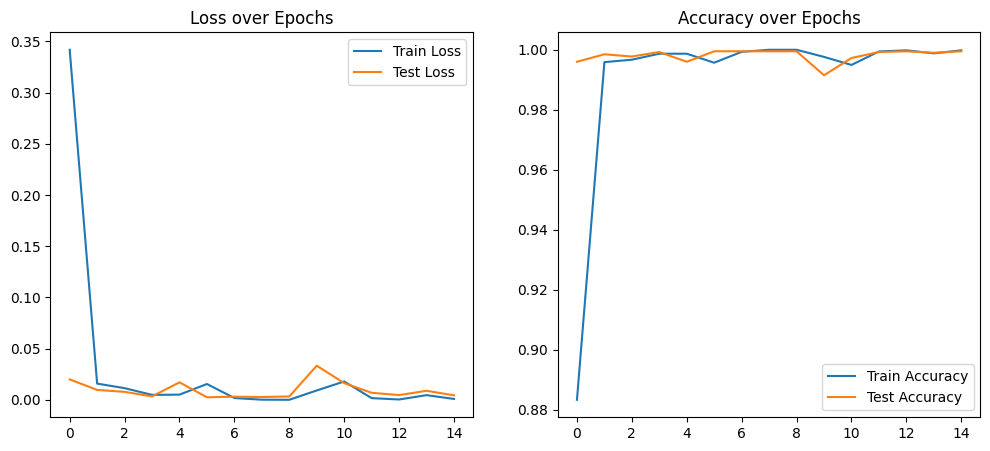

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


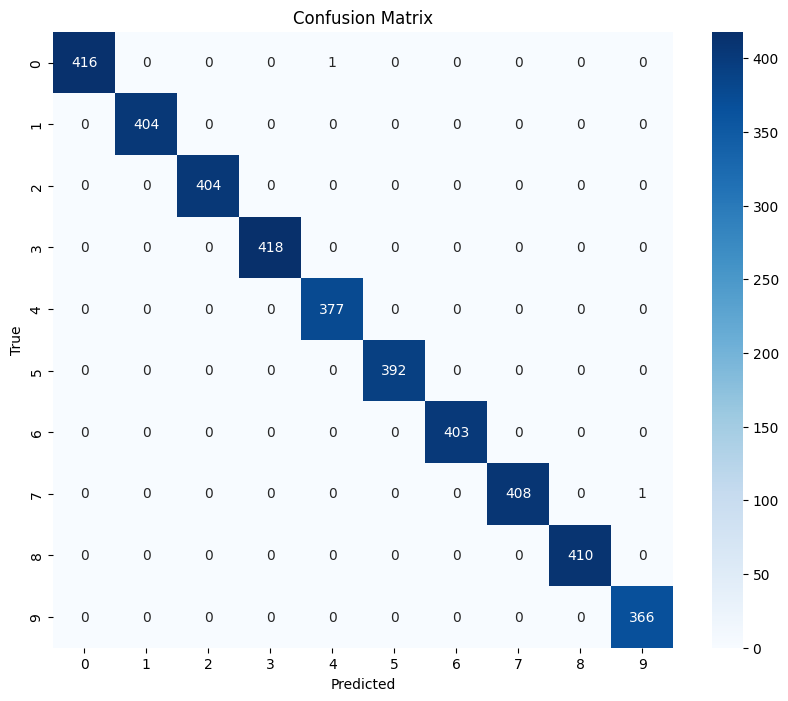

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       404
           2       1.00      1.00      1.00       404
           3       1.00      1.00      1.00       418
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.00       392
           6       1.00      1.00      1.00       403
           7       1.00      1.00      1.00       409
           8       1.00      1.00      1.00       410
           9       1.00      1.00      1.00       366

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [20]:
_, _, y_pred, y_true = evaluate(model, test_loader)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))


/tmp/ipykernel_36/1323173595.py:18: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


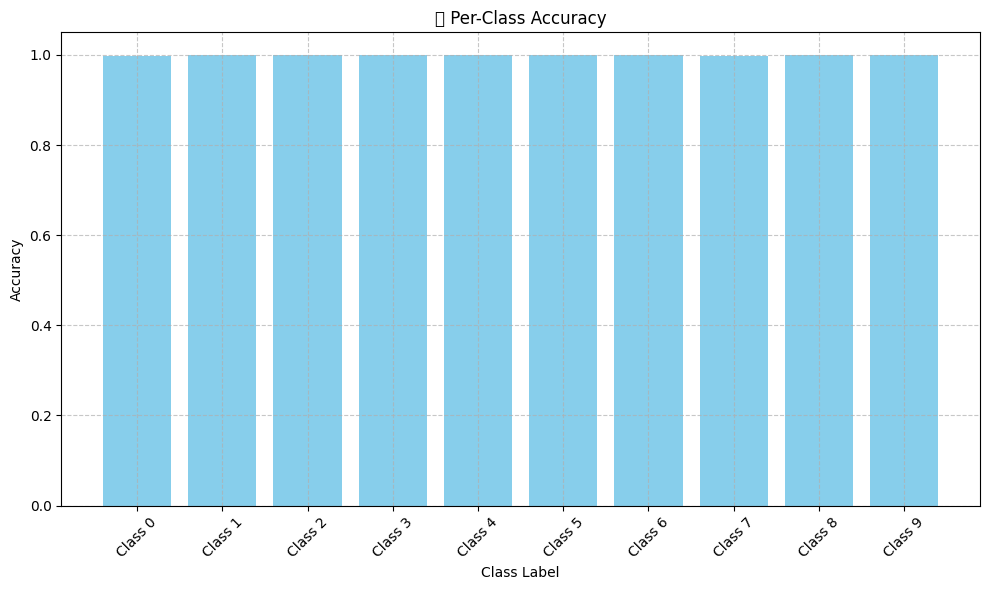

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get class-wise accuracy from confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(class_accuracy)), class_accuracy, color='skyblue')
plt.title("🎯 Per-Class Accuracy")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.xticks(np.arange(len(class_accuracy)), [f"Class {i}" for i in range(len(class_accuracy))], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


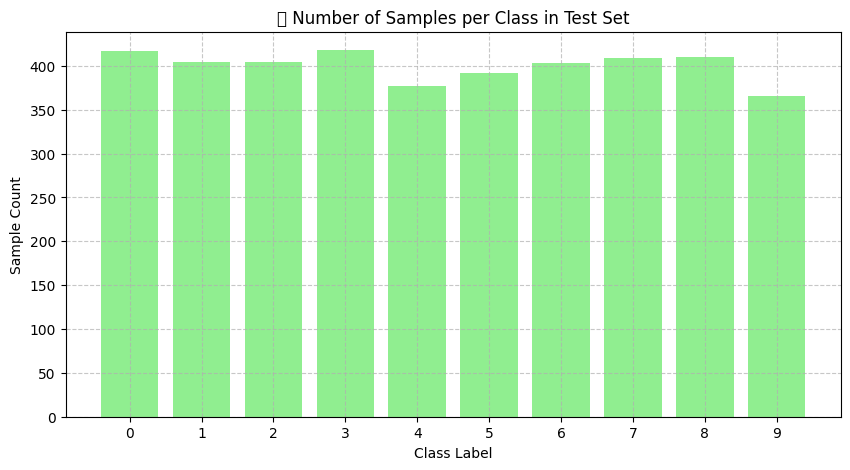

In [24]:
from collections import Counter

class_counts = Counter(y_true)
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.title("📦 Number of Samples per Class in Test Set")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.xticks(list(class_counts.keys()))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


/tmp/ipykernel_36/1178904951.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


<Figure size 1200x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


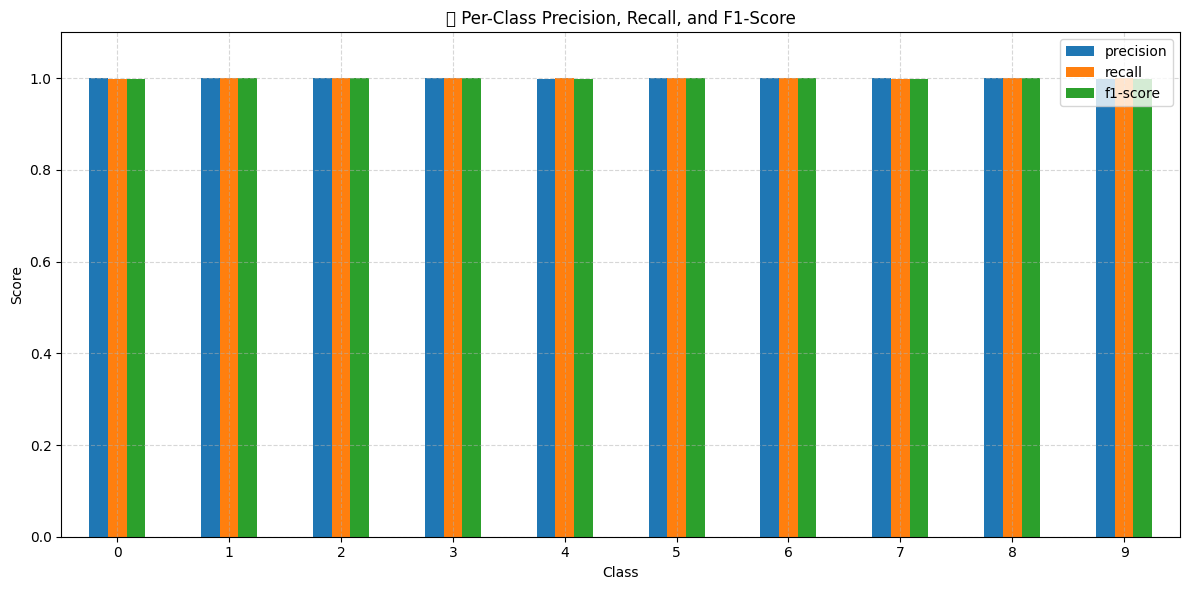

In [26]:
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(12,5))
df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12,6))
plt.title("📊 Per-Class Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipykernel_36/3242771351.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


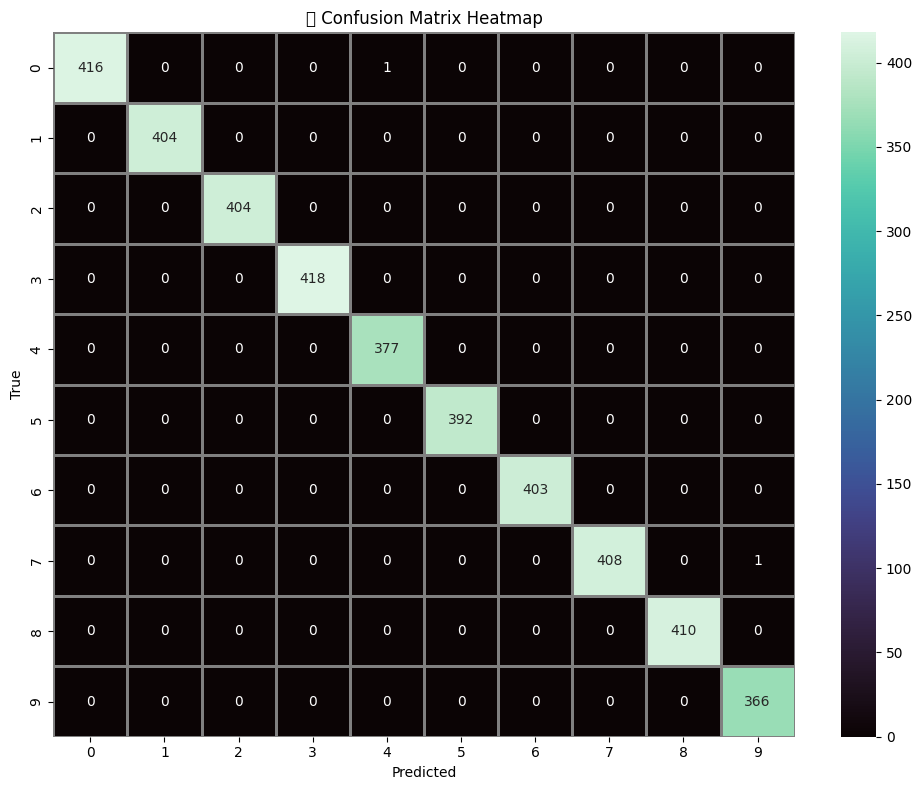

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', linewidths=1, linecolor='gray')
plt.title("🔥 Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [30]:
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            out = model.features(inputs)
            out = out.view(out.size(0), -1)  # Flatten
            features.append(out.cpu())
            labels.extend(targets)

    features = torch.cat(features).numpy()
    labels = np.array(labels)
    return features, labels

# ✅ Extract features now
features, labels = extract_features(model, test_loader)


In [31]:
import umap
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# UMAP to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(features_scaled)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/tmp/ipykernel_36/3741746505.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


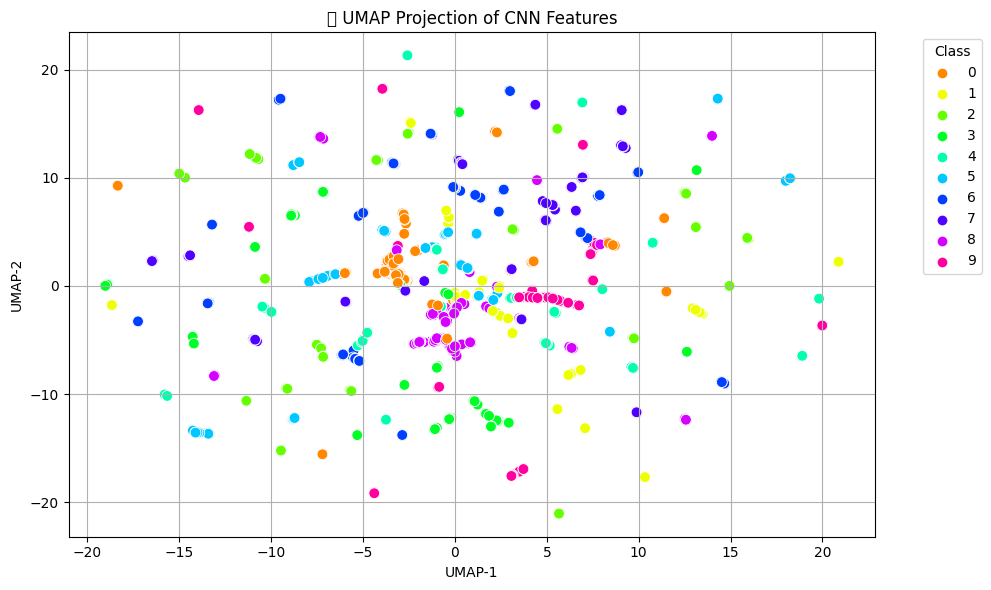

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", np.unique(labels).max() + 1)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette=palette, legend="full", s=60)
plt.title("📊 UMAP Projection of CNN Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Prediction Images

In [33]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_predicted_images(model, dataset, num_images=8):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(16, 6))
    
    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            confidence, pred_label = torch.max(probs, 1)
        
        # Plot image
        plt.subplot(2, num_images // 2, i+1)
        plt.imshow(image.squeeze().numpy(), cmap="gray")
        plt.title(f"Pred: {pred_label.item()} ({confidence.item()*100:.2f}%)\nTrue: {true_label}")
        plt.axis("off")
    
    plt.suptitle("🧠 Predicted Images with Confidence Scores", fontsize=16)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_36/44844928.py:26: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


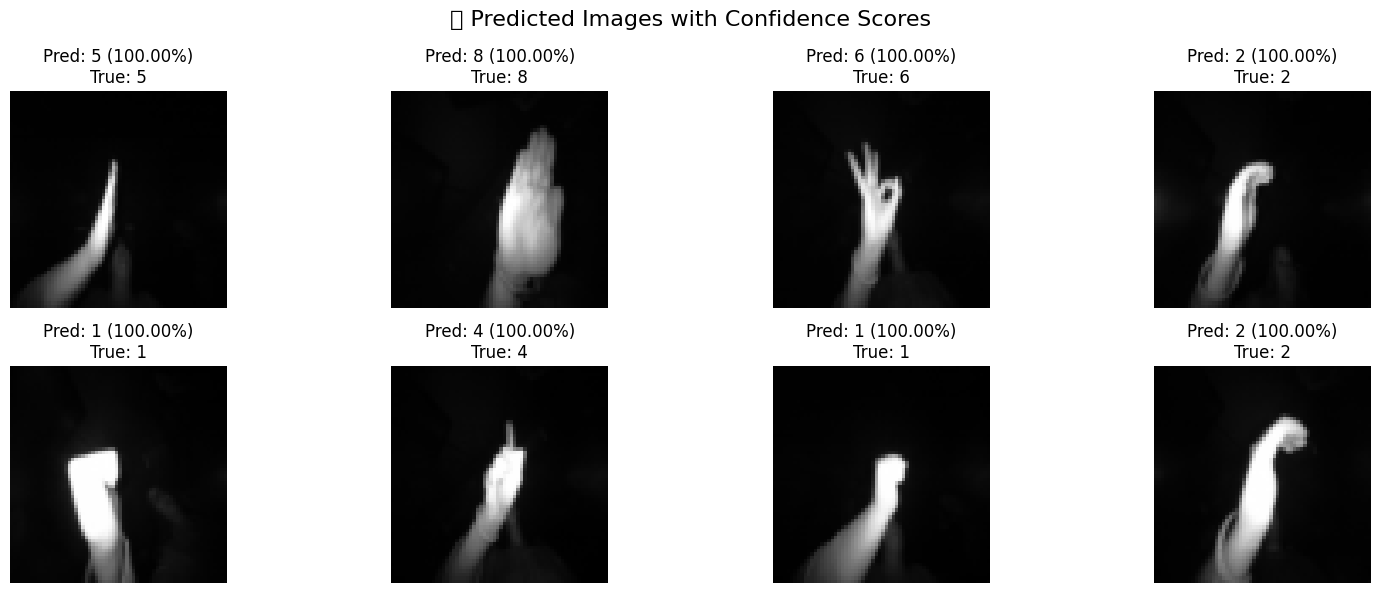

In [34]:
# Show 8 random test images with predictions and confidence
show_predicted_images(model, test_set, num_images=8)


/tmp/ipykernel_36/1957096935.py:23: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()


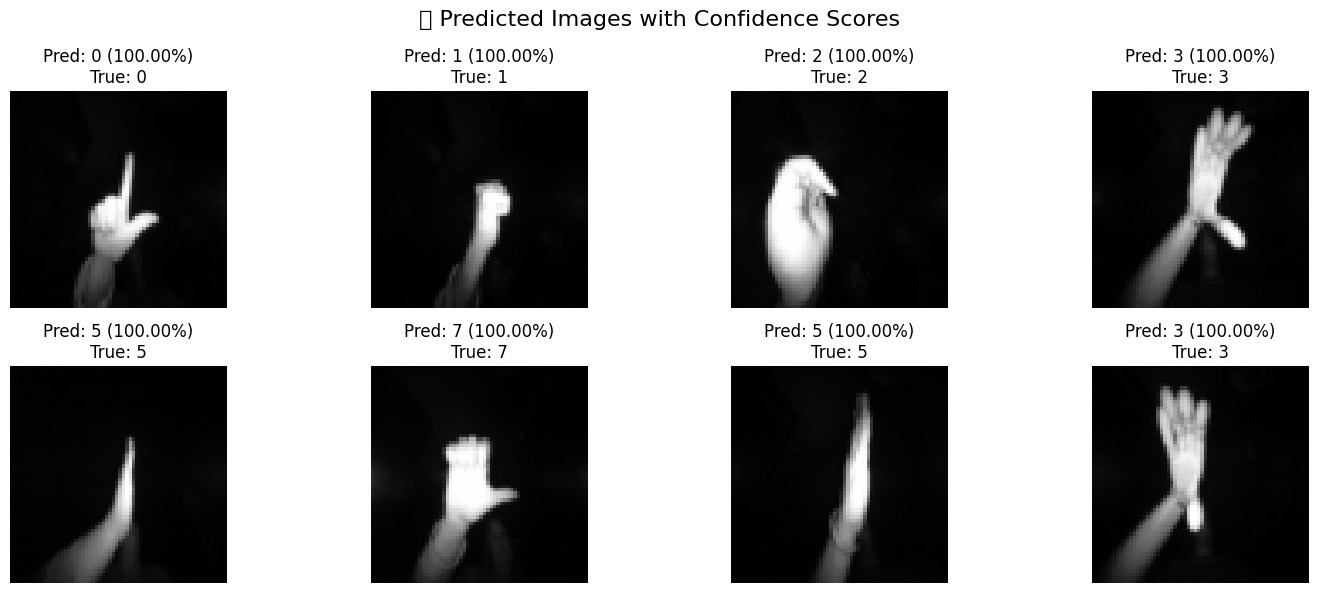

In [37]:
# Run on test_set (or train_set for debugging)
show_predicted_images(model, test_set, num_images=8)
